In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
#import kerastuner as kt
from sklearn.model_selection import train_test_split

In [ ]:
# only the number of maxima
df_spectra_all=pd.read_csv("spectrum_energy_input_numberOfPeaks.csv",index_col=[0])
all_data = df_spectra_all[["k6a1","k6a2","k11","k12","k9a1","k9a2","no_of_max"]]
# drop all rows containing 0.5 to make it binary
print(len(all_data))
all_data = all_data.query('k6a1 != 0.5 & k6a2 != 0.5 & k11 != 0.5 & k12 != 0.5 & k9a1 != 0.5 & k9a2 != 0.5')
print(len(all_data))
#set the values to zero and one
#labels = ['k6a1','k6a2','k11','k12','k9a1','k9a2']
#[all_data[i].mask(all_data[i] == 0.25, 0, inplace=True) for i in labels]
#[all_data[i].mask(all_data[i] == 0.75, 1, inplace=True) for i in labels]
#print(all_data.head(10))
data_train, data_test = train_test_split(all_data, test_size=0.20, random_state=42)

In [ ]:
feature_columns_A = []

no_of_max = tf.feature_column.numeric_column("no_of_max")
#my_feature_layer_A = tf.keras.layers.DenseFeatures(no_of_max_bucket)
feature_columns_A.append(no_of_max)
k6a1 = tf.feature_column.numeric_column("k6a1")
feature_columns_A.append(k6a1)
k6a2 = tf.feature_column.numeric_column("k6a2")
feature_columns_A.append(k6a2)
k11 = tf.feature_column.numeric_column("k11")
feature_columns_A.append(k11)
k12 = tf.feature_column.numeric_column("k12")
feature_columns_A.append(k12)
k9a1 = tf.feature_column.numeric_column("k9a1")
feature_columns_A.append(k9a1)
k9a2 = tf.feature_column.numeric_column("k9a2")
feature_columns_A.append(k9a2)

my_feature_layer_A = tf.keras.layers.DenseFeatures(feature_columns_A)

In [ ]:
def plot_curve(epochs, hist, list_of_metrics):
    """Plot a curve of one or more classification metrics vs. epoch."""  
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)
    plt.legend()

In [ ]:
# for activation functions check https://keras.io/api/layers/activations/
def create_model2(my_learning_rate, my_feature_layer,my_metrics,my_act_function = "softmax"):
    model = tf.keras.models.Sequential()
    model.add(my_feature_layer)
    layers=[20,12]
    for layer in layers:
        model.add(tf.keras.layers.Dense(units = layer, activation = my_act_function))
    model.add(tf.keras.layers.Dense(units=6,name='Output', activation = 'softmax'))                             
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                       
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)
    return model


def train_model(model, dataset, epochs, label_name,
                batch_size=None,shuffle=True):
    features = {name:np.array(value) for name, value in dataset.items()}
    label=dataset[label_name].to_numpy()
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    return epochs, hist

In [ ]:
learning_rate = 1e-2
epochs = 50
batch_size = 12

#specify the classification threshold
classification_threshold = 0.15

# Establish the metrics the model will measure.
metric = [tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,name='precision'),
      tf.keras.metrics.Recall(thresholds=classification_threshold,name='recall'),]

label_name = ["k6a1","k6a2","k11","k12","k9a1","k9a2"]
#label_name = "k6a1"
my_model = create_model2(learning_rate, my_feature_layer_A,metric,my_act_function="sigmoid")
epochs, hist = train_model(my_model, data_train, epochs, 
                          label_name, batch_size)
# Plot a graph of the metric(s) vs. epochs.
#list_of_metrics_to_plot = ['accuracy'] 
list_of_metrics_to_plot = ['accuracy', 'precision', 'recall'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)

In [ ]:
features = {name:np.array(value) for name, value in data_test.items()}
label=data_test[label_name].to_numpy()
print("\n Evaluate the new model against the test set:")
evaluation=my_model.evaluate(x = features, y = label, batch_size=batch_size)
predicted = my_model.predict(features)
print(predicted)
df_test=pd.DataFrame(label,columns=["k6a1_test","k6a2_test","k11_test","k12_test","k9a1_test","k9a2_test"])
#df_test=pd.DataFrame(label,columns=["k6a1_test"])
df_predict=pd.DataFrame(predicted,columns=["k6a1_hat","k6a2_hat","k11_hat","k12_hat","k9a1_hat","k9a2_hat"])
#df_predict=pd.DataFrame(predicted,columns=["k6a1_hat"])
#df_test = df_test.round(0)
#df_predict = df_predict.round(0)
pd.concat([df_test,df_predict], axis=1).head()

# Umbauen in ein echtes Klassifizierungsproblem

see https://sebastianraschka.com/faq/docs/softmax_regression.html

Wir haben für jede Konstante drei mögliche Werte: 0.25, 0.5 und 0.75 - das ist somit ein "ternary" (dreifaltiges?) Klassifikationsproblem. Die softmax Funktion am Ende des Modells gibt eine Wahrscheinlichkeit an, inwiefern das "feature" zu welcher Klasse gehört (prozentual). 

Ich würde mal anfangen und für k6a1 ein Modell bauen mit one-hot encoding für die drei möglichen Werte und als feature die Anzahl der Peaks. Das gleiche für ausschliesslich k6a2, k11, k12, k9a1, k9a2. Vermutlich wird das nicht so gut funktionieren weil die Information einfach nicht ausreichend ist. Da würde ich mal versuchen zu verstehen, welche Vorhersagen dir das Modell gibt, und dass du die Wahrscheinlichkeiten für die drei möglichen Klassen bekommst, für jedes Beispiel.

Im zweiten Schritt würde ich dann andere Klassen-Kombinationen probieren:
Klasse 1 - k6a1, k11, k9a1 
Klasse 2 - k6a2, k12, k9a2 

Sagen wir, die jeweiligen Werte liegen bei -1 (momentan 0.25), 0 (momentan 0.5), 1 (momentan 0.75). Die Summe aller Werte liegt damit zwischen -3 und +3.

Dann wäre Fall A: sum(Klasse 1) < -1; Fall B: -1 < sum(Klasse 1) < 1; Fall C: sum(Klasse 1) > 1. Mit den Grenzen kann man etwas herumspielen; und das gleiche jeweils für Klasse 2.

Oder vielleicht hast du noch andere Ideen.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
#import kerastuner as kt
from sklearn.model_selection import train_test_split

In [ ]:
df_spectra_all=pd.read_csv("spectrum_energy_input_numberOfPeaks.csv",index_col=[0])
all_data = df_spectra_all[["k6a1","k6a2","k11","k12","k9a1","k9a2","no_of_max"]]

all_data=pd.get_dummies(all_data,columns=["k6a1","k6a2","k11","k12","k9a1","k9a2"])


#all_data["k6a1"]=all_data[["k6a1_0.25","k6a1_0.5","k6a1_0.75"]].values.tolist()
#all_data["k6a2"]=all_data[["k6a1_0.25","k6a1_0.5","k6a1_0.75"]].values.tolist()
#all_data["k11"]=all_data[["k11_0.25","k11_0.5","k11_0.75"]].values.tolist()
#all_data["k12"]=all_data[["k12_0.25","k12_0.5","k12_0.75"]].values.tolist()
#all_data["k9a1"]=all_data[["k9a1_0.25","k9a1_0.5","k9a1_0.75"]].values.tolist()
#all_data["k9a2"]=all_data[["k9a2_0.25","k9a2_0.5","k9a2_0.75"]].values.tolist()
#all_data=all_data.drop(columns=["k6a1_0.25","k6a1_0.5","k6a1_0.75","k6a2_0.25","k6a2_0.5","k6a2_0.75","k11_0.25",
#                                "k11_0.5","k11_0.75","k12_0.25","k12_0.5","k12_0.75","k9a1_0.25","k9a1_0.5",
#                                "k9a1_0.75","k9a2_0.25","k9a2_0.5","k9a2_0.75"])

data_train, data_test = train_test_split(all_data, test_size=0.20, random_state=42)
data_train.head()

In [ ]:
feature_columns_A = []

no_of_max = tf.feature_column.numeric_column("no_of_max")
#my_feature_layer_A = tf.keras.layers.DenseFeatures(no_of_max_bucket)
feature_columns_A.append(no_of_max)
#k6a1 = tf.feature_column.numeric_column("k6a1")
#feature_columns_A.append(k6a1)
#k6a2 = tf.feature_column.numeric_column("k6a2")
#feature_columns_A.append(k6a2)
#k11 = tf.feature_column.numeric_column("k11")
#feature_columns_A.append(k11)
#k12 = tf.feature_column.numeric_column("k12")
#feature_columns_A.append(k12)
#k9a1 = tf.feature_column.numeric_column("k9a1")
#feature_columns_A.append(k9a1)
#k9a2 = tf.feature_column.numeric_column("k9a2")
#feature_columns_A.append(k9a2)

my_feature_layer_A = tf.keras.layers.DenseFeatures(feature_columns_A)




def plot_curve(epochs, hist, list_of_metrics):
    """Plot a curve of one or more classification metrics vs. epoch."""  
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)
    plt.legend()
    
    
# for activation functions check https://keras.io/api/layers/activations/
def create_model2(my_learning_rate, my_feature_layer,my_metrics,my_act_function = "softmax"):
    model = tf.keras.models.Sequential()
    model.add(my_feature_layer)
    layers=[20,12]
    for layer in layers:
        model.add(tf.keras.layers.Dense(units = layer, activation = my_act_function))
    model.add(tf.keras.layers.Dense(units=18,name='Output', activation = 'softmax'))                             
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                       
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)
    return model


def train_model(model, dataset, epochs, label_name,
                batch_size=None,shuffle=True):
    #features = {name:np.array(np.asarray(value)) for name, value in dataset.items()}

    features={"no_of_max":dataset["no_of_max"].to_numpy()}
   # print(features)

    #for multiple inputs
    print(type(label_name))
    if(type(label_name)==list):
        label=dataset[label_name].to_numpy()
        label_array=np.zeros((label.shape[0],label.shape[1],3))
        for i in range(label.shape[0]):
            for j in range(label.shape[1]):
                for k in range(len(label[i,j])):
                    label_array[i,j,k]=label[i,j][k]
            #print(label_array[i,j])
           # print(type(label_array[i,j]))
        print(label_array.shape) 
        label=label_array
    else:
        label=dataset[label_name].to_numpy()
        label_array=np.zeros((label.shape[0],3))
        for i in range(label.shape[0]):
            for k in range(len(label[i])):
                label_array[i,k]=label[i][k]
          
        print(label_array.shape) 
        label=label_array
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    return epochs, hist


def train_model2(model, dataset, epochs, label_name,
                batch_size=None,shuffle=True):
    #features = {name:np.array(np.asarray(value)) for name, value in dataset.items()}

    features={"no_of_max":dataset["no_of_max"].to_numpy()}
   # print(features)
    label=dataset[label_name].to_numpy()

    
    
    
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    return epochs, hist

In [ ]:
learning_rate = 1e-1
epochs = 500
batch_size = 12

#specify the classification threshold
classification_threshold = 0.15

# Establish the metrics the model will measure.
metric = [tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,name='precision'),
      tf.keras.metrics.Recall(thresholds=classification_threshold,name='recall'),]

#label_name = ["k6a1","k6a2","k11","k12","k9a1","k9a2"]
#label_name = "k6a1"
label_name=["k6a1_0.25","k6a1_0.5","k6a1_0.75","k6a2_0.25","k6a2_0.5","k6a2_0.75","k11_0.25","k11_0.5","k11_0.75","k12_0.25","k12_0.5","k12_0.75","k9a1_0.25","k9a1_0.5","k9a1_0.75","k9a2_0.25","k9a2_0.5","k9a2_0.75"]
my_model = create_model2(learning_rate, my_feature_layer_A,metric,my_act_function="softmax")

# Plot a graph of the metric(s) vs. epochs.
#list_of_metrics_to_plot = ['accuracy'] 


In [ ]:
epochs, hist = train_model2(my_model, data_train, epochs, 
                          label_name, batch_size)

In [ ]:
list_of_metrics_to_plot = ['accuracy', 'precision', 'recall'] 

plot_curve(epochs, hist, list_of_metrics_to_plot)

if(type(label_name)==list):
    label=data_test[label_name].to_numpy()
    label_array=np.zeros((label.shape[0],label.shape[1],3))
    for i in range(label.shape[0]):
        for j in range(label.shape[1]):
            for k in range(len(label[i,j])):
                label_array[i,j,k]=label[i,j][k]
        #print(label_array[i,j])
       # print(type(label_array[i,j]))
    #print(label_array.shape) 
    label=label_array
else:
    label=data_test[label_name].to_numpy()
    label_array=np.zeros((label.shape[0],3))
    for i in range(label.shape[0]):
        for k in range(len(label[i])):
            label_array[i,k]=label[i][k]

    #print(label_array.shape) 
    label=label_array


In [ ]:
features={"no_of_max":data_test["no_of_max"].to_numpy()}
label=data_test[label_name].to_numpy()
#print(label.reshape((len(label),6,3)))

print("\n Evaluate the new model against the test set:")




evaluation=my_model.evaluate(x = features, y = label, batch_size=batch_size)

predicted = my_model.predict(features)

label=label.reshape((len(label),6,3))

predicted=predicted.reshape((len(predicted),6,3))
print(predicted.shape)

label_list=["k6a1","k6a2","k11","k12","k9a1","k9a2"]
for i in range(predicted.shape[0]):
    print("Test No:", i)
    for j in range(predicted.shape[1]):
        #print(1/sum(predicted[i,j]))
        print(label_list[j],"Label: ",label[i,j],"predicted: ", predicted[i,j]*1/sum(predicted[i,j]) )
print()

        
  


df_test=pd.DataFrame(label,columns=["k6a1_test","k6a2_test","k11_test","k12_test","k9a1_test","k9a2_test"])
#df_test=pd.DataFrame(label,columns=["k6a1_0.25_label","k6a1_0.5_label","k6a1_0.75_label"])
df_predict=pd.DataFrame(predicted,columns=["k6a1_hat","k6a2_hat","k11_hat","k12_hat","k9a1_hat","k9a2_hat"])
#df_predict=pd.DataFrame(predicted,columns=["k6a1_0.25","k6a1_0.5","k6a1_0.75"])
#df_test = df_test.round(0)
#df_predict = df_predict.round(0)
pd.concat([df_test,df_predict], axis=1).head(50)

In [1]:
#class predictions
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
#import kerastuner as kt
from sklearn.model_selection import train_test_split

H:\Users\Gwydion\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
H:\Users\Gwydion\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
H:\Users\Gwydion\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
H:\Users\Gwydion\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub

In [96]:
df_spectra_all=pd.read_csv("spectrum_energy_input_numberOfPeaks.csv",index_col=[0])
all_data = df_spectra_all[["k6a1","k6a2","k11","k12","k9a1","k9a2","no_of_max"]]
no_data_points=(len(all_data["k6a1"].values))
#all_data=pd.get_dummies(all_data,columns=["k6a1","k6a2","k11","k12","k9a1","k9a2"])

#values between 0.75 and 2.25
#different classes:
#0 all < 0.5
#1 all > 0.5
#2 k6a1,k11,k9a1 >0.5, k6a2,k11,k9a2 <0.5
#3 k6a1,k11,k9a1 <0.5, k6a2,k11,k9a2 >0.5
#4 k6a1 == k6a2 
#5 k11 == k12 
#6 k9a1 == k9a2 
#7 sum(k6a1,k11,k9a1) < 1.25
#8 sum(k6a1,k11,k9a1) > 2
#9 sum(k6a2,k12,k9a2) < 1.25
#10 sum(k6a2,k12,k9a2) > 2

print(all_data.head())
#class_array=np.zeros((no_data_points,11))
all_data.loc[(all_data['k6a1'] <0.5) & (all_data['k6a2'] <0.5)& (all_data['k11'] <0.5)
                        & (all_data['k12'] <0.5)& (all_data['k9a1'] <0.5)&( all_data['k9a2'] <0.5), 'Class0'] = 1  
all_data.loc[(all_data['k6a1'] >0.5) & (all_data['k6a2'] >0.5)& (all_data['k11'] >0.5)
                        & (all_data['k12'] >0.5)& (all_data['k9a1'] >0.5)&( all_data['k9a2'] >0.5), 'Class1'] = 1  

all_data.loc[(all_data['k6a1'] >0.5) & (all_data['k6a2'] <0.5)& (all_data['k11'] >0.5)
                        & (all_data['k12'] <0.5)& (all_data['k9a1'] >0.5)&( all_data['k9a2'] <0.5), 'Class2'] = 1  
all_data.loc[(all_data['k6a1'] <0.5) & (all_data['k6a2'] >0.5)& (all_data['k11'] <0.5)
                        & (all_data['k12'] >0.5)& (all_data['k9a1'] <0.5)&( all_data['k9a2'] >0.5), 'Class3'] = 1  
all_data.loc[(all_data['k6a1'] == all_data['k6a2']), 'Class4'] = 1  
all_data.loc[(all_data['k11'] == all_data['k12']), 'Class5'] = 1  
all_data.loc[(all_data['k9a1'] == all_data['k9a2']), 'Class6'] = 1  
all_data.loc[((all_data['k6a1']+all_data['k11']+all_data['k9a1'])<1.25 ), 'Class7'] = 1  
all_data.loc[((all_data['k6a1']+all_data['k11']+all_data['k9a1'])>2 ), 'Class8'] = 1  
all_data.loc[((all_data['k6a2']+all_data['k12']+all_data['k9a2'])<1.25 ), 'Class9'] = 1  
all_data.loc[((all_data['k6a2']+all_data['k12']+all_data['k9a2'])>2 ), 'Class10'] = 1  








all_data=all_data.fillna(0)


data_train, data_test = train_test_split(all_data, test_size=0.20, random_state=42)
data_train.corr()


   k6a1  k6a2   k11   k12  k9a1  k9a2  no_of_max
0  0.25  0.25  0.25  0.25  0.25  0.25         18
1  0.25  0.25  0.25  0.25  0.25  0.50          5
2  0.25  0.25  0.25  0.25  0.25  0.75         19
3  0.25  0.25  0.25  0.25  0.50  0.25         19
4  0.25  0.25  0.25  0.25  0.50  0.50          5


H:\Users\Gwydion\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
H:\Users\Gwydion\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,k6a1,k6a2,k11,k12,k9a1,k9a2,no_of_max,Class0,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9,Class10
k6a1,1.000000,-0.014436,0.032982,0.004645,0.006471,-0.032706,0.017681,-0.051884,0.048776,0.048776,-0.051884,0.009783,0.022311,-0.022162,-0.406803,0.249072,0.025215,-0.018353
k6a2,-0.014436,1.000000,-0.012776,-0.012616,-0.004417,0.017738,-0.005897,-0.049801,0.051717,-0.049801,0.051717,0.051889,-0.001600,-0.005880,-0.002483,-0.015845,-0.379386,0.247072
k11,0.032982,-0.012776,1.000000,0.007696,-0.000066,-0.002537,-0.033564,-0.050703,0.050529,0.050529,-0.050703,-0.037293,-0.001473,0.002954,-0.364680,0.258020,-0.012634,-0.011406
k12,0.004645,-0.012616,0.007696,1.000000,-0.062370,-0.023034,0.016413,-0.051471,0.050422,-0.051471,0.050422,-0.022257,-0.008898,-0.008967,0.024826,0.007729,-0.389879,0.240887
k9a1,0.006471,-0.004417,-0.000066,-0.062370,1.000000,0.007950,0.007243,-0.052077,0.049464,0.049464,-0.052077,-0.008257,0.013546,-0.004529,-0.383847,0.252585,0.028075,-0.006241
k9a2,-0.032706,0.017738,-0.002537,-0.023034,0.007950,1.000000,-0.008690,-0.050206,0.050900,-0.050206,0.050900,0.023674,0.019222,0.023667,0.003433,-0.008555,-0.378105,0.243168
no_of_max,0.017681,-0.005897,-0.033564,0.016413,0.007243,-0.008690,1.000000,0.052853,0.058455,0.058455,0.058455,0.041952,-0.027708,0.026348,0.019443,-0.004750,0.013504,0.291430
Class0,-0.051884,-0.049801,-0.050703,-0.051471,-0.052077,-0.050206,0.052853,1.000000,-0.001718,-0.001718,-0.001718,0.060084,0.058924,0.058471,0.101030,-0.008774,0.098974,-0.008209
Class1,0.048776,0.051717,0.050529,0.050422,0.049464,0.050900,0.058455,-0.001718,1.000000,-0.001718,-0.001718,0.060084,0.058924,0.058471,-0.017007,0.195833,-0.017360,0.209319
Class2,0.048776,-0.049801,0.050529,-0.051471,0.049464,-0.050206,0.058455,-0.001718,-0.001718,1.000000,-0.001718,-0.028597,-0.029160,-0.029386,-0.017007,0.195833,0.098974,-0.008209


In [73]:
feature_columns_A = []

no_of_max = tf.feature_column.numeric_column("no_of_max")
feature_columns_A.append(no_of_max)

my_feature_layer_A = tf.keras.layers.DenseFeatures(feature_columns_A)




def plot_curve(epochs, hist, list_of_metrics):
    """Plot a curve of one or more classification metrics vs. epoch."""  
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)
    plt.legend()
    
    
# for activation functions check https://keras.io/api/layers/activations/
def create_model2(my_learning_rate, my_feature_layer,my_metrics,my_act_function = "softmax"):
    model = tf.keras.models.Sequential()
    model.add(my_feature_layer)
    layers=[20,25,15,12]
    for layer in layers:
        model.add(tf.keras.layers.Dense(units = layer, activation = my_act_function))
    model.add(tf.keras.layers.Dense(units=11,name='Output', activation = 'softmax'))                             
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                       
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)
    return model

def train_model2(model, dataset, epochs, label_name,
                batch_size=None,shuffle=True):
    #features = {name:np.array(np.asarray(value)) for name, value in dataset.items()}

    features={"no_of_max":dataset["no_of_max"].to_numpy()}
   # print(features)
    label=dataset[label_name].to_numpy()

    
    
    
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    return epochs, hist

In [87]:
learning_rate = 1e-4
epochs = 13500
batch_size = 300
print(len(data_train))
#specify the classification threshold
classification_threshold = 0.125

# Establish the metrics the model will measure.
metric = [tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,name='precision'),
      tf.keras.metrics.Recall(thresholds=classification_threshold,name='recall'),]

label_name=["Class0","Class1","Class2","Class3","Class4","Class5","Class6","Class7","Class8","Class9","Class10"]
my_model = create_model2(learning_rate, my_feature_layer_A,metric,my_act_function="sigmoid")

# Plot a graph of the metric(s) vs. epochs.
#list_of_metrics_to_plot = ['accuracy'] 


583


In [88]:
epochs_list, hist = train_model2(my_model, data_train, epochs, 
                          label_name, batch_size)

Epoch 1/13500
2/2 [==============================] - 0s 892us/step - loss: 0.4265 - accuracy: 0.6565 - precision: 0.0983 - recall: 0.2155
Epoch 2/13500
2/2 [==============================] - 0s 891us/step - loss: 0.4258 - accuracy: 0.6565 - precision: 0.0983 - recall: 0.2155
Epoch 3/13500
2/2 [==============================] - 0s 445us/step - loss: 0.4253 - accuracy: 0.6565 - precision: 0.0983 - recall: 0.2155
Epoch 4/13500
2/2 [==============================] - 0s 891us/step - loss: 0.4248 - accuracy: 0.6565 - precision: 0.0983 - recall: 0.2155
Epoch 5/13500
2/2 [==============================] - 0s 891us/step - loss: 0.4244 - accuracy: 0.6565 - precision: 0.0983 - recall: 0.2155
Epoch 6/13500
2/2 [==============================] - 0s 892us/step - loss: 0.4241 - accuracy: 0.6565 - precision: 0.0983 - recall: 0.2155
Epoch 7/13500
2/2 [==============================] - 0s 891us/step - loss: 0.4237 - accuracy: 0.6565 - precision: 0.0983 - recall: 0.2155
Epoch 8/13500
2/2 [===============

Epoch 60/13500
2/2 [==============================] - 0s 891us/step - loss: 0.4088 - accuracy: 0.6565 - precision: 0.0983 - recall: 0.2155
Epoch 61/13500
2/2 [==============================] - 0s 1ms/step - loss: 0.4085 - accuracy: 0.6565 - precision: 0.0983 - recall: 0.2155
Epoch 62/13500
2/2 [==============================] - 0s 891us/step - loss: 0.4082 - accuracy: 0.6565 - precision: 0.0983 - recall: 0.2155
Epoch 63/13500
2/2 [==============================] - 0s 892us/step - loss: 0.4080 - accuracy: 0.6565 - precision: 0.0983 - recall: 0.2155
Epoch 64/13500
2/2 [==============================] - 0s 892us/step - loss: 0.4077 - accuracy: 0.6565 - precision: 0.0983 - recall: 0.2155
Epoch 65/13500
2/2 [==============================] - 0s 445us/step - loss: 0.4074 - accuracy: 0.6565 - precision: 0.0983 - recall: 0.2155
Epoch 66/13500
2/2 [==============================] - 0s 891us/step - loss: 0.4072 - accuracy: 0.6565 - precision: 0.0983 - recall: 0.2155
Epoch 67/13500
2/2 [=========

2/2 [==============================] - 0s 891us/step - loss: 0.3938 - accuracy: 0.6565 - precision: 0.0983 - recall: 0.2155
Epoch 119/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3935 - accuracy: 0.6565 - precision: 0.0983 - recall: 0.2155
Epoch 120/13500
2/2 [==============================] - 0s 446us/step - loss: 0.3933 - accuracy: 0.6565 - precision: 0.0983 - recall: 0.2155
Epoch 121/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3930 - accuracy: 0.6565 - precision: 0.0983 - recall: 0.2155
Epoch 122/13500
2/2 [==============================] - 0s 445us/step - loss: 0.3928 - accuracy: 0.6565 - precision: 0.0983 - recall: 0.2155
Epoch 123/13500
2/2 [==============================] - 0s 445us/step - loss: 0.3926 - accuracy: 0.6565 - precision: 0.0983 - recall: 0.2155
Epoch 124/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3923 - accuracy: 0.6565 - precision: 0.0983 - recall: 0.2155
Epoch 125/13500
2/2 [===============

2/2 [==============================] - 0s 891us/step - loss: 0.3801 - accuracy: 0.7170 - precision: 0.2093 - recall: 0.4586
Epoch 177/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3798 - accuracy: 0.7170 - precision: 0.2093 - recall: 0.4586
Epoch 178/13500
2/2 [==============================] - 0s 892us/step - loss: 0.3796 - accuracy: 0.7170 - precision: 0.2093 - recall: 0.4586
Epoch 179/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3794 - accuracy: 0.7170 - precision: 0.2093 - recall: 0.4586
Epoch 180/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3792 - accuracy: 0.7170 - precision: 0.2093 - recall: 0.4586
Epoch 181/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3789 - accuracy: 0.7170 - precision: 0.2093 - recall: 0.4586
Epoch 182/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3787 - accuracy: 0.7170 - precision: 0.2093 - recall: 0.4586
Epoch 183/13500
2/2 [===============

2/2 [==============================] - 0s 445us/step - loss: 0.3676 - accuracy: 0.7808 - precision: 0.2393 - recall: 0.3496
Epoch 235/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3674 - accuracy: 0.7808 - precision: 0.2393 - recall: 0.3496
Epoch 236/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3672 - accuracy: 0.7808 - precision: 0.2393 - recall: 0.3496
Epoch 237/13500
2/2 [==============================] - 0s 446us/step - loss: 0.3670 - accuracy: 0.7808 - precision: 0.2393 - recall: 0.3496
Epoch 238/13500
2/2 [==============================] - 0s 445us/step - loss: 0.3668 - accuracy: 0.7808 - precision: 0.2393 - recall: 0.3496
Epoch 239/13500
2/2 [==============================] - 0s 892us/step - loss: 0.3666 - accuracy: 0.7808 - precision: 0.2393 - recall: 0.3496
Epoch 240/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3664 - accuracy: 0.7808 - precision: 0.2393 - recall: 0.3496
Epoch 241/13500
2/2 [===============

2/2 [==============================] - 0s 891us/step - loss: 0.3564 - accuracy: 0.7808 - precision: 0.2393 - recall: 0.3496
Epoch 293/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3562 - accuracy: 0.7808 - precision: 0.2393 - recall: 0.3496
Epoch 294/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3561 - accuracy: 0.7808 - precision: 0.2393 - recall: 0.3496
Epoch 295/13500
2/2 [==============================] - 0s 892us/step - loss: 0.3559 - accuracy: 0.7808 - precision: 0.2393 - recall: 0.3496
Epoch 296/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3557 - accuracy: 0.7808 - precision: 0.2393 - recall: 0.3496
Epoch 297/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3555 - accuracy: 0.7808 - precision: 0.2393 - recall: 0.3496
Epoch 298/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3553 - accuracy: 0.7808 - precision: 0.2393 - recall: 0.3496
Epoch 299/13500
2/2 [===============

2/2 [==============================] - 0s 891us/step - loss: 0.3465 - accuracy: 0.8455 - precision: 0.3345 - recall: 0.2444
Epoch 351/13500
2/2 [==============================] - 0s 446us/step - loss: 0.3464 - accuracy: 0.8455 - precision: 0.3345 - recall: 0.2444
Epoch 352/13500
2/2 [==============================] - 0s 890us/step - loss: 0.3462 - accuracy: 0.8455 - precision: 0.3345 - recall: 0.2444
Epoch 353/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3461 - accuracy: 0.8455 - precision: 0.3345 - recall: 0.2444
Epoch 354/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3459 - accuracy: 0.8455 - precision: 0.3345 - recall: 0.2444
Epoch 355/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3457 - accuracy: 0.8455 - precision: 0.3345 - recall: 0.2444
Epoch 356/13500
2/2 [==============================] - 0s 892us/step - loss: 0.3456 - accuracy: 0.8455 - precision: 0.3345 - recall: 0.2444
Epoch 357/13500
2/2 [===============

2/2 [==============================] - 0s 891us/step - loss: 0.3379 - accuracy: 0.8132 - precision: 0.3285 - recall: 0.4799
Epoch 409/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3378 - accuracy: 0.8132 - precision: 0.3285 - recall: 0.4799
Epoch 410/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3377 - accuracy: 0.8132 - precision: 0.3285 - recall: 0.4799
Epoch 411/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3375 - accuracy: 0.8132 - precision: 0.3285 - recall: 0.4799
Epoch 412/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3374 - accuracy: 0.8132 - precision: 0.3285 - recall: 0.4799
Epoch 413/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3372 - accuracy: 0.8132 - precision: 0.3285 - recall: 0.4799
Epoch 414/13500
2/2 [==============================] - 0s 892us/step - loss: 0.3371 - accuracy: 0.8132 - precision: 0.3285 - recall: 0.4799
Epoch 415/13500
2/2 [===============

2/2 [==============================] - 0s 891us/step - loss: 0.3305 - accuracy: 0.8132 - precision: 0.3285 - recall: 0.4799
Epoch 467/13500
2/2 [==============================] - 0s 446us/step - loss: 0.3304 - accuracy: 0.8132 - precision: 0.3285 - recall: 0.4799
Epoch 468/13500
2/2 [==============================] - 0s 446us/step - loss: 0.3303 - accuracy: 0.8132 - precision: 0.3285 - recall: 0.4799
Epoch 469/13500
2/2 [==============================] - 0s 445us/step - loss: 0.3302 - accuracy: 0.8132 - precision: 0.3285 - recall: 0.4799
Epoch 470/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3301 - accuracy: 0.8132 - precision: 0.3285 - recall: 0.4799
Epoch 471/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3299 - accuracy: 0.8132 - precision: 0.3285 - recall: 0.4799
Epoch 472/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3298 - accuracy: 0.8132 - precision: 0.3285 - recall: 0.4799
Epoch 473/13500
2/2 [===============

2/2 [==============================] - 0s 445us/step - loss: 0.3242 - accuracy: 0.8132 - precision: 0.3285 - recall: 0.4799
Epoch 525/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3241 - accuracy: 0.8132 - precision: 0.3285 - recall: 0.4799
Epoch 526/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3240 - accuracy: 0.8132 - precision: 0.3285 - recall: 0.4799
Epoch 527/13500
2/2 [==============================] - 0s 446us/step - loss: 0.3239 - accuracy: 0.8132 - precision: 0.3285 - recall: 0.4799
Epoch 528/13500
2/2 [==============================] - 0s 445us/step - loss: 0.3238 - accuracy: 0.8132 - precision: 0.3285 - recall: 0.4799
Epoch 529/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3237 - accuracy: 0.8132 - precision: 0.3285 - recall: 0.4799
Epoch 530/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3235 - accuracy: 0.8132 - precision: 0.3285 - recall: 0.4799
Epoch 531/13500
2/2 [===============

2/2 [==============================] - 0s 891us/step - loss: 0.3186 - accuracy: 0.8132 - precision: 0.3285 - recall: 0.4799
Epoch 583/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3186 - accuracy: 0.8132 - precision: 0.3285 - recall: 0.4799
Epoch 584/13500
2/2 [==============================] - 0s 446us/step - loss: 0.3185 - accuracy: 0.8132 - precision: 0.3285 - recall: 0.4799
Epoch 585/13500
2/2 [==============================] - 0s 446us/step - loss: 0.3184 - accuracy: 0.8132 - precision: 0.3285 - recall: 0.4799
Epoch 586/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3183 - accuracy: 0.8132 - precision: 0.3285 - recall: 0.4799
Epoch 587/13500
2/2 [==============================] - 0s 446us/step - loss: 0.3182 - accuracy: 0.8132 - precision: 0.3285 - recall: 0.4799
Epoch 588/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3181 - accuracy: 0.8132 - precision: 0.3285 - recall: 0.4799
Epoch 589/13500
2/2 [===============

2/2 [==============================] - 0s 891us/step - loss: 0.3139 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 641/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3139 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 642/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3138 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 643/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3137 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 644/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3136 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 645/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3136 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 646/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3135 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 647/13500
2/2 [===============

2/2 [==============================] - 0s 891us/step - loss: 0.3100 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 699/13500
2/2 [==============================] - 0s 445us/step - loss: 0.3099 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 700/13500
2/2 [==============================] - 0s 446us/step - loss: 0.3098 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 701/13500
2/2 [==============================] - 0s 445us/step - loss: 0.3098 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 702/13500
2/2 [==============================] - 0s 445us/step - loss: 0.3097 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 703/13500
2/2 [==============================] - 0s 446us/step - loss: 0.3096 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 704/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3096 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 705/13500
2/2 [===============

2/2 [==============================] - 0s 891us/step - loss: 0.3067 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 757/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3066 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 758/13500
2/2 [==============================] - 0s 885us/step - loss: 0.3066 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 759/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3065 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 760/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3065 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 761/13500
2/2 [==============================] - 0s 892us/step - loss: 0.3064 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 762/13500
2/2 [==============================] - 0s 446us/step - loss: 0.3064 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 763/13500
2/2 [===============

2/2 [==============================] - 0s 892us/step - loss: 0.3039 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 815/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3038 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 816/13500
2/2 [==============================] - 0s 445us/step - loss: 0.3038 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 817/13500
2/2 [==============================] - 0s 446us/step - loss: 0.3038 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 818/13500
2/2 [==============================] - 0s 445us/step - loss: 0.3037 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 819/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3037 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 820/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3036 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 821/13500
2/2 [===============

2/2 [==============================] - 0s 892us/step - loss: 0.3015 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 873/13500
2/2 [==============================] - 0s 446us/step - loss: 0.3015 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 874/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3015 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 875/13500
2/2 [==============================] - 0s 446us/step - loss: 0.3014 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 876/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3014 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 877/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3013 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 878/13500
2/2 [==============================] - 0s 891us/step - loss: 0.3013 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 879/13500
2/2 [===============

2/2 [==============================] - 0s 891us/step - loss: 0.2995 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 931/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2995 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 932/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2995 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 933/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2994 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 934/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2994 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 935/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2994 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 936/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2993 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 937/13500
2/2 [===============

2/2 [==============================] - 0s 445us/step - loss: 0.2979 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 989/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2978 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 990/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2978 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 991/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2978 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 992/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2978 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 993/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2977 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 994/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2977 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 995/13500
2/2 [===============

2/2 [==============================] - 0s 445us/step - loss: 0.2965 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1047/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2965 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1048/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2964 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1049/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2964 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1050/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2964 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1051/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2964 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1052/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2964 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1053/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2954 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1105/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2954 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1106/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2954 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1107/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2953 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1108/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2953 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1109/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2953 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1110/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2953 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1111/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2945 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1163/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2945 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1164/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2945 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1165/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2945 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1166/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2944 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1167/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2944 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1168/13500
2/2 [==============================] - 0s 860us/step - loss: 0.2944 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1169/13500
2/2 [========

2/2 [==============================] - 0s 445us/step - loss: 0.2938 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1221/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2938 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1222/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2938 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1223/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2937 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1224/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2937 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1225/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2937 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1226/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2937 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1227/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2932 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1279/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2932 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1280/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2932 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1281/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2932 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1282/13500
2/2 [==============================] - 0s 890us/step - loss: 0.2932 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1283/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2932 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1284/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2931 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1285/13500
2/2 [========

2/2 [==============================] - 0s 890us/step - loss: 0.2927 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1337/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2927 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1338/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2927 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1339/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2927 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1340/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2927 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1341/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2927 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1342/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2927 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1343/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2924 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1395/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2924 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1396/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2924 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1397/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2924 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1398/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2923 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1399/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2923 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1400/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2923 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1401/13500
2/2 [========

2/2 [==============================] - 0s 446us/step - loss: 0.2921 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1453/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2921 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1454/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2921 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1455/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2921 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1456/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2921 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1457/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2920 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1458/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2920 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1459/13500
2/2 [========

2/2 [==============================] - 0s 446us/step - loss: 0.2918 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1511/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2918 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1512/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2918 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1513/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2918 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1514/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2918 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1515/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2918 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1516/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2918 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1517/13500
2/2 [========

2/2 [==============================] - 0s 446us/step - loss: 0.2916 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1569/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2916 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1570/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2916 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1571/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2916 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1572/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2916 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1573/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2916 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1574/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2916 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1575/13500
2/2 [========

2/2 [==============================] - 0s 445us/step - loss: 0.2915 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1627/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2915 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1628/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2915 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1629/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2915 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1630/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2915 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1631/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2915 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1632/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2915 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1633/13500
2/2 [========

2/2 [==============================] - 0s 445us/step - loss: 0.2914 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1685/13500
2/2 [==============================] - 0s 890us/step - loss: 0.2914 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1686/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2914 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1687/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2914 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1688/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2914 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1689/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2914 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1690/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2914 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1691/13500
2/2 [========

2/2 [==============================] - 0s 446us/step - loss: 0.2913 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1743/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2913 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1744/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2913 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1745/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2913 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1746/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2913 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1747/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2913 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1748/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2913 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1749/13500
2/2 [========

2/2 [==============================] - 0s 446us/step - loss: 0.2912 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1801/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2912 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1802/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2912 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1803/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2912 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1804/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2912 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1805/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2912 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1806/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2912 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1807/13500
2/2 [========

2/2 [==============================] - 0s 445us/step - loss: 0.2911 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1859/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2911 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1860/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2911 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1861/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2911 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1862/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2911 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1863/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2911 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1864/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2911 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1865/13500
2/2 [========

2/2 [==============================] - 0s 446us/step - loss: 0.2911 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1917/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2911 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1918/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2911 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1919/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2911 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1920/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2911 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1921/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2911 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1922/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2911 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1923/13500
2/2 [========

2/2 [==============================] - 0s 446us/step - loss: 0.2911 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1974/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2911 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1975/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2911 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1976/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2911 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1977/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2911 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1978/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2911 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1979/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2911 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 1980/13500
2/2 [========

2/2 [==============================] - 0s 446us/step - loss: 0.2910 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2032/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2910 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2033/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2910 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2034/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2910 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2035/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2910 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2036/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2910 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2037/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2910 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2038/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2910 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2090/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2910 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2091/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2910 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2092/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2910 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2093/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2910 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2094/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2910 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2095/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2910 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2096/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2910 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2148/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2910 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2149/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2910 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2150/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2910 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2151/13500
2/2 [==============================] - 0s 731us/step - loss: 0.2910 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2152/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2910 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2153/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2910 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2154/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2910 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2206/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2910 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2207/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2910 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2208/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2910 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2209/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2910 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2210/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2910 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2211/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2910 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2212/13500
2/2 [========

2/2 [==============================] - 0s 445us/step - loss: 0.2909 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2264/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2909 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2265/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2909 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2266/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2909 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2267/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2909 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2268/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2909 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2269/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2909 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2270/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2909 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2322/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2909 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2323/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2909 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2324/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2909 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2325/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2909 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2326/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2909 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2327/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2909 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2328/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2909 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2380/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2909 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2381/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2909 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2382/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2909 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2383/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2909 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2384/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2909 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2385/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2909 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2386/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2909 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2438/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2909 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2439/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2909 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2440/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2909 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2441/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2909 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2442/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2909 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2443/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2909 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2444/13500
2/2 [========

2/2 [==============================] - 0s 445us/step - loss: 0.2908 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2496/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2908 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2497/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2908 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2498/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2908 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2499/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2908 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2500/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2908 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2501/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2908 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2502/13500
2/2 [========

2/2 [==============================] - 0s 892us/step - loss: 0.2908 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2554/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2908 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2555/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2908 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2556/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2908 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2557/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2908 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2558/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2908 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2559/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2908 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2560/13500
2/2 [========

2/2 [==============================] - 0s 450us/step - loss: 0.2908 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2612/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2908 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2613/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2908 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2614/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2908 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2615/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2908 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2616/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2908 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2617/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2908 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2618/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2907 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2670/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2907 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2671/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2907 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2672/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2907 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2673/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2907 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2674/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2907 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2675/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2907 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2676/13500
2/2 [========

2/2 [==============================] - 0s 445us/step - loss: 0.2907 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2728/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2907 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2729/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2907 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2730/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2907 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2731/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2907 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2732/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2907 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2733/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2907 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2734/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2906 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2786/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2906 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2787/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2906 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2788/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2906 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2789/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2906 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2790/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2906 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2791/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2906 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2792/13500
2/2 [========

2/2 [==============================] - 0s 446us/step - loss: 0.2906 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2844/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2906 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2845/13500
2/2 [==============================] - 0s 888us/step - loss: 0.2906 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2846/13500
2/2 [==============================] - 0s 1ms/step - loss: 0.2906 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2847/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2906 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2848/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2906 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2849/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2906 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2850/13500
2/2 [==========

2/2 [==============================] - 0s 446us/step - loss: 0.2905 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2902/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2905 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2903/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2905 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2904/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2905 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2905/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2905 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2906/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2905 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2907/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2905 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2908/13500
2/2 [========

2/2 [==============================] - 0s 446us/step - loss: 0.2904 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2960/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2904 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2961/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2904 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2962/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2904 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2963/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2904 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2964/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2904 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2965/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2904 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 2966/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2904 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3018/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2904 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3019/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2904 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3020/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2904 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3021/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2904 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3022/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2904 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3023/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2903 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3024/13500
2/2 [========

2/2 [==============================] - 0s 890us/step - loss: 0.2903 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3076/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2903 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3077/13500
2/2 [==============================] - 0s 1ms/step - loss: 0.2903 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3078/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2903 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3079/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2903 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3080/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2903 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3081/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2903 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3082/13500
2/2 [==========

2/2 [==============================] - 0s 445us/step - loss: 0.2902 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3134/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2902 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3135/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2902 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3136/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2902 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3137/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2902 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3138/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2902 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3139/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2902 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3140/13500
2/2 [========

2/2 [==============================] - 0s 445us/step - loss: 0.2901 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3192/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2901 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3193/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2901 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3194/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2901 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3195/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2901 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3196/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2901 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3197/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2901 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3198/13500
2/2 [========

2/2 [==============================] - 0s 892us/step - loss: 0.2900 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3250/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2900 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3251/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2900 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3252/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2900 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3253/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2900 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3254/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2900 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3255/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2900 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3256/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2899 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3308/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2899 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3309/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2899 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3310/13500
2/2 [==============================] - 0s 957us/step - loss: 0.2899 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3311/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2899 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3312/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2899 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3313/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2899 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3314/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2898 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3366/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2898 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3367/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2898 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3368/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2898 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3369/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2898 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3370/13500
2/2 [==============================] - 0s 890us/step - loss: 0.2898 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3371/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2898 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3372/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2897 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3424/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2897 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3425/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2897 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3426/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2897 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3427/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2897 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3428/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2897 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3429/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2896 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3430/13500
2/2 [========

2/2 [==============================] - 0s 446us/step - loss: 0.2896 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3482/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2896 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3483/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2895 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3484/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2895 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3485/13500
2/2 [==============================] - 0s 755us/step - loss: 0.2896 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3486/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2895 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3487/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2895 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3488/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2895 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3540/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2894 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3541/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2894 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3542/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2894 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3543/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2894 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3544/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2894 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3545/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2894 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3546/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2893 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3598/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2893 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3599/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2893 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3600/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2893 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3601/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2893 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3602/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2893 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3603/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2893 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3604/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2892 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3656/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2892 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3657/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2892 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3658/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2892 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3659/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2892 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3660/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2892 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3661/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2892 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3662/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2891 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3714/13500
2/2 [==============================] - 0s 890us/step - loss: 0.2891 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3715/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2891 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3716/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2891 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3717/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2891 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3718/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2891 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3719/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2891 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3720/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2890 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3772/13500
2/2 [==============================] - 0s 890us/step - loss: 0.2890 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3773/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2890 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3774/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2890 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3775/13500
2/2 [==============================] - 0s 1ms/step - loss: 0.2890 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3776/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2890 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3777/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2890 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3778/13500
2/2 [==========

2/2 [==============================] - 0s 891us/step - loss: 0.2889 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3830/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2889 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3831/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2889 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3832/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2889 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3833/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2889 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3834/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2889 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3835/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2889 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3836/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2888 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3888/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2888 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3889/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2888 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3890/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2888 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3891/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2888 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3892/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2888 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3893/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2888 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3894/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2887 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3946/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2887 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3947/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2887 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3948/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2887 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3949/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2887 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3950/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2887 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3951/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2887 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 3952/13500
2/2 [========

2/2 [==============================] - 0s 445us/step - loss: 0.2886 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4004/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2886 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4005/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2886 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4006/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2886 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4007/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2886 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4008/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2886 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4009/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2886 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4010/13500
2/2 [========

2/2 [==============================] - 0s 445us/step - loss: 0.2885 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4062/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2885 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4063/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2885 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4064/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2885 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4065/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2885 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4066/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2885 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4067/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2885 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4068/13500
2/2 [========

2/2 [==============================] - 0s 446us/step - loss: 0.2884 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4120/13500
2/2 [==============================] - 0s 1ms/step - loss: 0.2884 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4121/13500
2/2 [==============================] - 0s 1ms/step - loss: 0.2884 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4122/13500
2/2 [==============================] - 0s 1ms/step - loss: 0.2884 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4123/13500
2/2 [==============================] - 0s 1ms/step - loss: 0.2884 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4124/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2884 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4125/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2884 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4126/13500
2/2 [================

2/2 [==============================] - 0s 891us/step - loss: 0.2883 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4178/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2883 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4179/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2883 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4180/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2883 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4181/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2883 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4182/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2883 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4183/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2883 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4184/13500
2/2 [========

2/2 [==============================] - 0s 890us/step - loss: 0.2882 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4236/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2882 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4237/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2882 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4238/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2882 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4239/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2882 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4240/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2882 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4241/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2882 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4242/13500
2/2 [========

2/2 [==============================] - 0s 446us/step - loss: 0.2881 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4294/13500
2/2 [==============================] - 0s 1ms/step - loss: 0.2881 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4295/13500
2/2 [==============================] - 0s 1ms/step - loss: 0.2881 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4296/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2881 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4297/13500
2/2 [==============================] - 0s 1ms/step - loss: 0.2881 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4298/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2881 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4299/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2881 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4300/13500
2/2 [==============

2/2 [==============================] - 0s 891us/step - loss: 0.2880 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4352/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2880 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4353/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2880 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4354/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2880 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4355/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2880 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4356/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2880 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4357/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2880 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4358/13500
2/2 [========

2/2 [==============================] - 0s 445us/step - loss: 0.2879 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4410/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2879 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4411/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2879 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4412/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2879 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4413/13500
2/2 [==============================] - 0s 890us/step - loss: 0.2879 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4414/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2879 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4415/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2879 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4416/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2878 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4468/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2878 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4469/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2878 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4470/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2878 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4471/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2878 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4472/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2878 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4473/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2878 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4474/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2877 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4526/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2877 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4527/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2877 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4528/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2877 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4529/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2877 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4530/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2877 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4531/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2877 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4532/13500
2/2 [========

2/2 [==============================] - 0s 892us/step - loss: 0.2876 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4584/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2876 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4585/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2876 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4586/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2876 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4587/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2876 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4588/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2876 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4589/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2876 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4590/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2875 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4642/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2875 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4643/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2875 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4644/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2875 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4645/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2875 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4646/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2875 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4647/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2875 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4648/13500
2/2 [========

2/2 [==============================] - 0s 445us/step - loss: 0.2874 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4700/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2874 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4701/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2874 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4702/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2874 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4703/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2874 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4704/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2874 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4705/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2874 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4706/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2873 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4758/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2873 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4759/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2873 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4760/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2873 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4761/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2873 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4762/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2873 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4763/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2873 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4764/13500
2/2 [========

2/2 [==============================] - 0s 445us/step - loss: 0.2872 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4816/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2872 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4817/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2872 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4818/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2872 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4819/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2872 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4820/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2872 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4821/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2872 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4822/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2871 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4874/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2871 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4875/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2871 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4876/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2871 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4877/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2871 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4878/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2871 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4879/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2871 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4880/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2870 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4932/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2870 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4933/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2870 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4934/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2870 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4935/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2870 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4936/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2870 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4937/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2870 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4938/13500
2/2 [========

2/2 [==============================] - 0s 445us/step - loss: 0.2869 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4990/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2869 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4991/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2869 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4992/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2869 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4993/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2869 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4994/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2869 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4995/13500
2/2 [==============================] - 0s 452us/step - loss: 0.2869 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 4996/13500
2/2 [========

2/2 [==============================] - 0s 445us/step - loss: 0.2868 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5048/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2868 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5049/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2868 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5050/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2868 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5051/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2868 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5052/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2868 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5053/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2868 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5054/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2867 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5106/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2867 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5107/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2867 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5108/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2867 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5109/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2867 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5110/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2867 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5111/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2867 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5112/13500
2/2 [========

2/2 [==============================] - 0s 892us/step - loss: 0.2866 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5164/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2866 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5165/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2866 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5166/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2866 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5167/13500
2/2 [==============================] - 0s 890us/step - loss: 0.2866 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5168/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2866 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5169/13500
2/2 [==============================] - 0s 447us/step - loss: 0.2866 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5170/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2865 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5222/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2865 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5223/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2865 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5224/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2865 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5225/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2865 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5226/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2865 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5227/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2865 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5228/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2864 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5280/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2864 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5281/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2864 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5282/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2864 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5283/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2864 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5284/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2864 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5285/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2864 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5286/13500
2/2 [========

2/2 [==============================] - 0s 892us/step - loss: 0.2863 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5338/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2863 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5339/13500
2/2 [==============================] - 0s 897us/step - loss: 0.2863 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5340/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2863 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5341/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2863 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5342/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2863 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5343/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2863 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5344/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2862 - accuracy: 0.7825 - precision: 0.3293 - recall: 0.7218
Epoch 5396/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2862 - accuracy: 0.7823 - precision: 0.3291 - recall: 0.7218
Epoch 5397/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2862 - accuracy: 0.7823 - precision: 0.3291 - recall: 0.7218
Epoch 5398/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2862 - accuracy: 0.7823 - precision: 0.3291 - recall: 0.7218
Epoch 5399/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2862 - accuracy: 0.7823 - precision: 0.3291 - recall: 0.7218
Epoch 5400/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2862 - accuracy: 0.7823 - precision: 0.3291 - recall: 0.7218
Epoch 5401/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2862 - accuracy: 0.7823 - precision: 0.3291 - recall: 0.7218
Epoch 5402/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2861 - accuracy: 0.7818 - precision: 0.3292 - recall: 0.7256
Epoch 5454/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2861 - accuracy: 0.7818 - precision: 0.3292 - recall: 0.7256
Epoch 5455/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2861 - accuracy: 0.7818 - precision: 0.3292 - recall: 0.7256
Epoch 5456/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2861 - accuracy: 0.7818 - precision: 0.3292 - recall: 0.7256
Epoch 5457/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2861 - accuracy: 0.7818 - precision: 0.3292 - recall: 0.7256
Epoch 5458/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2861 - accuracy: 0.7818 - precision: 0.3292 - recall: 0.7256
Epoch 5459/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2861 - accuracy: 0.7818 - precision: 0.3292 - recall: 0.7256
Epoch 5460/13500
2/2 [========

2/2 [==============================] - 0s 446us/step - loss: 0.2860 - accuracy: 0.7818 - precision: 0.3292 - recall: 0.7256
Epoch 5512/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2860 - accuracy: 0.7818 - precision: 0.3292 - recall: 0.7256
Epoch 5513/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2860 - accuracy: 0.7818 - precision: 0.3292 - recall: 0.7256
Epoch 5514/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2860 - accuracy: 0.7818 - precision: 0.3292 - recall: 0.7256
Epoch 5515/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2860 - accuracy: 0.7818 - precision: 0.3292 - recall: 0.7256
Epoch 5516/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2859 - accuracy: 0.7818 - precision: 0.3292 - recall: 0.7256
Epoch 5517/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2859 - accuracy: 0.7818 - precision: 0.3292 - recall: 0.7256
Epoch 5518/13500
2/2 [========

2/2 [==============================] - 0s 446us/step - loss: 0.2859 - accuracy: 0.7818 - precision: 0.3292 - recall: 0.7256
Epoch 5570/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2859 - accuracy: 0.7818 - precision: 0.3292 - recall: 0.7256
Epoch 5571/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2858 - accuracy: 0.7818 - precision: 0.3292 - recall: 0.7256
Epoch 5572/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2859 - accuracy: 0.7818 - precision: 0.3292 - recall: 0.7256
Epoch 5573/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2859 - accuracy: 0.7818 - precision: 0.3292 - recall: 0.7256
Epoch 5574/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2858 - accuracy: 0.7818 - precision: 0.3292 - recall: 0.7256
Epoch 5575/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2858 - accuracy: 0.7818 - precision: 0.3292 - recall: 0.7256
Epoch 5576/13500
2/2 [========

2/2 [==============================] - 0s 892us/step - loss: 0.2857 - accuracy: 0.7818 - precision: 0.3292 - recall: 0.7256
Epoch 5628/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2857 - accuracy: 0.7818 - precision: 0.3292 - recall: 0.7256
Epoch 5629/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2858 - accuracy: 0.7818 - precision: 0.3292 - recall: 0.7256
Epoch 5630/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2857 - accuracy: 0.7818 - precision: 0.3292 - recall: 0.7256
Epoch 5631/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2857 - accuracy: 0.7818 - precision: 0.3292 - recall: 0.7256
Epoch 5632/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2857 - accuracy: 0.7818 - precision: 0.3292 - recall: 0.7256
Epoch 5633/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2857 - accuracy: 0.7818 - precision: 0.3292 - recall: 0.7256
Epoch 5634/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2856 - accuracy: 0.7818 - precision: 0.3292 - recall: 0.7256
Epoch 5686/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2856 - accuracy: 0.7818 - precision: 0.3292 - recall: 0.7256
Epoch 5687/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2856 - accuracy: 0.7723 - precision: 0.3232 - recall: 0.7581
Epoch 5688/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2856 - accuracy: 0.7714 - precision: 0.3218 - recall: 0.7556
Epoch 5689/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2856 - accuracy: 0.7709 - precision: 0.3211 - recall: 0.7544
Epoch 5690/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2856 - accuracy: 0.7818 - precision: 0.3292 - recall: 0.7256
Epoch 5691/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2856 - accuracy: 0.7726 - precision: 0.3235 - recall: 0.7581
Epoch 5692/13500
2/2 [========

2/2 [==============================] - 0s 445us/step - loss: 0.2855 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 5744/13500
2/2 [==============================] - 0s 888us/step - loss: 0.2855 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 5745/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2855 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 5746/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2855 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 5747/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2855 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 5748/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2855 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 5749/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2855 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 5750/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2854 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 5802/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2854 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 5803/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2854 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 5804/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2854 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 5805/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2854 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 5806/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2854 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 5807/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2854 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 5808/13500
2/2 [========

2/2 [==============================] - 0s 446us/step - loss: 0.2853 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 5860/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2853 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 5861/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2853 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 5862/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2853 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 5863/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2853 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 5864/13500
2/2 [==============================] - 0s 1ms/step - loss: 0.2853 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 5865/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2853 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 5866/13500
2/2 [==========

2/2 [==============================] - 0s 891us/step - loss: 0.2852 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 5918/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2852 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 5919/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2852 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 5920/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2852 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 5921/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2852 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 5922/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2852 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 5923/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2852 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 5924/13500
2/2 [========

2/2 [==============================] - 0s 446us/step - loss: 0.2851 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 5976/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2851 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 5977/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2851 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 5978/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2851 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 5979/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2851 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 5980/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2851 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 5981/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2851 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 5982/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2849 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6034/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2849 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6035/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2849 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6036/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2849 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6037/13500
2/2 [==============================] - 0s 890us/step - loss: 0.2849 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6038/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2849 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6039/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2849 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6040/13500
2/2 [========

2/2 [==============================] - 0s 446us/step - loss: 0.2848 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6092/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2848 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6093/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2848 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6094/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2848 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6095/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2848 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6096/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2848 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6097/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2848 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6098/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2847 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6150/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2847 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6151/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2847 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6152/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2847 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6153/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2847 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6154/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2847 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6155/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2847 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6156/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2846 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6208/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2846 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6209/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2846 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6210/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2846 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6211/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2846 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6212/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2846 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6213/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2846 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6214/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2845 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6266/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2845 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6267/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2845 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6268/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2845 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6269/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2845 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6270/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2845 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6271/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2845 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6272/13500
2/2 [========

2/2 [==============================] - 0s 1ms/step - loss: 0.2844 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6324/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2844 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6325/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2844 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6326/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2844 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6327/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2844 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6328/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2844 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6329/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2844 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6330/13500
2/2 [==========

2/2 [==============================] - 0s 446us/step - loss: 0.2843 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6382/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2843 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6383/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2843 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6384/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2843 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6385/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2843 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6386/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2843 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6387/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2843 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6388/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2842 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6440/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2842 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6441/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2842 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6442/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2842 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6443/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2842 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6444/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2842 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6445/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2842 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6446/13500
2/2 [========

2/2 [==============================] - 0s 446us/step - loss: 0.2841 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6498/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2841 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6499/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2841 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6500/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2841 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6501/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2841 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6502/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2840 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6503/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2840 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6504/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2840 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6556/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2840 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6557/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2840 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6558/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2840 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6559/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2840 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6560/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2840 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6561/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2839 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6562/13500
2/2 [========

2/2 [==============================] - 0s 446us/step - loss: 0.2839 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6614/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2839 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6615/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2839 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6616/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2839 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6617/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2838 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6618/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2839 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6619/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2838 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6620/13500
2/2 [========

2/2 [==============================] - 0s 1ms/step - loss: 0.2838 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6672/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2838 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6673/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2838 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6674/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2838 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6675/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2838 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6676/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2838 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6677/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2838 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6678/13500
2/2 [==========

2/2 [==============================] - 0s 891us/step - loss: 0.2837 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6730/13500
2/2 [==============================] - 0s 894us/step - loss: 0.2837 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6731/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2837 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6732/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2837 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6733/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2837 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6734/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2837 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6735/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2837 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6736/13500
2/2 [========

2/2 [==============================] - 0s 446us/step - loss: 0.2836 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6788/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2836 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6789/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2836 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6790/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2836 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6791/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2836 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6792/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2836 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6793/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2836 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6794/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2835 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6846/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2835 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6847/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2835 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6848/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2835 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6849/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2835 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6850/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2835 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6851/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2835 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6852/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2834 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6904/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2834 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6905/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2834 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6906/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2834 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6907/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2834 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6908/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2834 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6909/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2834 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6910/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2833 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6962/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2833 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6963/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2833 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6964/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2833 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6965/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2833 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6966/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2833 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6967/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2833 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 6968/13500
2/2 [========

2/2 [==============================] - 0s 892us/step - loss: 0.2833 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 7020/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2833 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 7021/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2833 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 7022/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2833 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 7023/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2833 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 7024/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2833 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 7025/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2833 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 7026/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2832 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 7078/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2832 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 7079/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2832 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 7080/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2832 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 7081/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2832 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 7082/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2832 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 7083/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2832 - accuracy: 0.7634 - precision: 0.3202 - recall: 0.8020
Epoch 7084/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2831 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7136/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2831 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7137/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2831 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7138/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2831 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7139/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2831 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7140/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2831 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7141/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2831 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7142/13500
2/2 [========

2/2 [==============================] - 0s 890us/step - loss: 0.2831 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7194/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2830 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7195/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2830 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7196/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2830 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7197/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2830 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7198/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2830 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7199/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2830 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7200/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2830 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7252/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2830 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7253/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2830 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7254/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2830 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7255/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2830 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7256/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2830 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7257/13500
2/2 [==============================] - 0s 890us/step - loss: 0.2830 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7258/13500
2/2 [========

2/2 [==============================] - 0s 445us/step - loss: 0.2829 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7310/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2829 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7311/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2829 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7312/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2829 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7313/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2829 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7314/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2829 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7315/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2829 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7316/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2829 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7368/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2829 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7369/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2829 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7370/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2829 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7371/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2829 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7372/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2829 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7373/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2829 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7374/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2828 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7426/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2828 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7427/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2828 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7428/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2828 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7429/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2828 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7430/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2828 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7431/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2828 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7432/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2828 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7484/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2828 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7485/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2828 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7486/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2828 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7487/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2828 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7488/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2828 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7489/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2828 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7490/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2827 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7542/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2827 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7543/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2827 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7544/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2827 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7545/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2827 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7546/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2827 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7547/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2827 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7548/13500
2/2 [========

2/2 [==============================] - 0s 1ms/step - loss: 0.2827 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7600/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2827 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7601/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2827 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7602/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2827 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7603/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2827 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7604/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2827 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7605/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2827 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7606/13500
2/2 [==========

2/2 [==============================] - 0s 891us/step - loss: 0.2826 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7658/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2826 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7659/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2826 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7660/13500
2/2 [==============================] - 0s 1ms/step - loss: 0.2826 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7661/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2826 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7662/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2826 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7663/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2826 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7664/13500
2/2 [==========

2/2 [==============================] - 0s 892us/step - loss: 0.2826 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7716/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2826 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7717/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2826 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7718/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2826 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7719/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2826 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7720/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2826 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7721/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2826 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7722/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2825 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7774/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2825 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7775/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2825 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7776/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2825 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7777/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2825 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7778/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2825 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7779/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2825 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7780/13500
2/2 [========

2/2 [==============================] - 0s 892us/step - loss: 0.2825 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7832/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2825 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7833/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2825 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7834/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2825 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7835/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2825 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7836/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2825 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7837/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2825 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7838/13500
2/2 [========

2/2 [==============================] - 0s 892us/step - loss: 0.2825 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7890/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2825 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7891/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2825 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7892/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2825 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7893/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2825 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7894/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2825 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7895/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2825 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7896/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2824 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7948/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2824 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7949/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2824 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7950/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2824 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7951/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2824 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7952/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2824 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7953/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2824 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 7954/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2824 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8006/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2824 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8007/13500
2/2 [==============================] - 0s 890us/step - loss: 0.2824 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8008/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2824 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8009/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2824 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8010/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2824 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8011/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2824 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8012/13500
2/2 [========

2/2 [==============================] - 0s 446us/step - loss: 0.2824 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8064/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2824 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8065/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2824 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8066/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2824 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8067/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2824 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8068/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2824 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8069/13500
2/2 [==============================] - 0s 890us/step - loss: 0.2824 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8070/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2823 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8122/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2823 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8123/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2823 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8124/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2823 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8125/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2823 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8126/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2823 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8127/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2823 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8128/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2823 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8180/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2823 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8181/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2823 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8182/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2823 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8183/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2823 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8184/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2823 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8185/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2823 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8186/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2823 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8238/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2823 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8239/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2823 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8240/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2823 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8241/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2823 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8242/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2823 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8243/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2823 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8244/13500
2/2 [========

2/2 [==============================] - 0s 1ms/step - loss: 0.2823 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8296/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2823 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8297/13500
2/2 [==============================] - 0s 1ms/step - loss: 0.2823 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8298/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2823 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8299/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2823 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8300/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2823 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8301/13500
2/2 [==============================] - 0s 1ms/step - loss: 0.2823 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8302/13500
2/2 [==============

2/2 [==============================] - 0s 891us/step - loss: 0.2822 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8354/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2822 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8355/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2822 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8356/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2822 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8357/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2822 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8358/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2822 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8359/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2822 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8360/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2822 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8412/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2822 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8413/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2822 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8414/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2822 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8415/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2822 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8416/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2822 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8417/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2822 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8418/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2822 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8470/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2822 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8471/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2822 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8472/13500
2/2 [==============================] - 0s 890us/step - loss: 0.2822 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8473/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2822 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8474/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2822 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8475/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2822 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8476/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2822 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8528/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2822 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8529/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2822 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8530/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2822 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8531/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2822 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8532/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2822 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8533/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2822 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8534/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2821 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8586/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2821 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8587/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2821 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8588/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2821 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8589/13500
2/2 [==============================] - 0s 897us/step - loss: 0.2821 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8590/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2821 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8591/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2821 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8592/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2821 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8644/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2821 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8645/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2821 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8646/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2821 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8647/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2821 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8648/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2821 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8649/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2821 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8650/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2821 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8702/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2821 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8703/13500
2/2 [==============================] - 0s 890us/step - loss: 0.2821 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8704/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2821 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8705/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2821 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8706/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2821 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8707/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2821 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8708/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2821 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8760/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2821 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8761/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2821 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8762/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2821 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8763/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2821 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8764/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2821 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8765/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2821 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8766/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8818/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8819/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8820/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8821/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2821 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8822/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2821 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8823/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8824/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8876/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8877/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8878/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8879/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8880/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8881/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8882/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8934/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8935/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8936/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8937/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8938/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8939/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8940/13500
2/2 [========

2/2 [==============================] - 0s 445us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8992/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8993/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8994/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8995/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8996/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8997/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 8998/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9050/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9051/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9052/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9053/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9054/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9055/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9056/13500
2/2 [========

2/2 [==============================] - 0s 445us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9108/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9109/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9110/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9111/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9112/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9113/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2820 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9114/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9166/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9167/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9168/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9169/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9170/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9171/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9172/13500
2/2 [========

2/2 [==============================] - 0s 1ms/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9224/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9225/13500
2/2 [==============================] - 0s 1ms/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9226/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9227/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9228/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9229/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9230/13500
2/2 [============

2/2 [==============================] - 0s 891us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9282/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9283/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9284/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9285/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9286/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9287/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9288/13500
2/2 [========

2/2 [==============================] - 0s 844us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9340/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9341/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9342/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9343/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9344/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9345/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9346/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9398/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9399/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9400/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9401/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9402/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9403/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9404/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9456/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9457/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9458/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9459/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9460/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9461/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2819 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9462/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9514/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9515/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9516/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9517/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9518/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9519/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9520/13500
2/2 [========

2/2 [==============================] - 0s 445us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9572/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9573/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9574/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9575/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9576/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9577/13500
2/2 [==============================] - 0s 897us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9578/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9630/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9631/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9632/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9633/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9634/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9635/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9636/13500
2/2 [========

2/2 [==============================] - 0s 445us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9688/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9689/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9690/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9691/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9692/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9693/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9694/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9746/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9747/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9748/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9749/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9750/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9751/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9752/13500
2/2 [========

2/2 [==============================] - 0s 445us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9804/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9805/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9806/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9807/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9808/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9809/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9810/13500
2/2 [========

2/2 [==============================] - 0s 892us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9862/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9863/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9864/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9865/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9866/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9867/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9868/13500
2/2 [========

2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9920/13500
2/2 [==============================] - 0s 1ms/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9921/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9922/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9923/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2818 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9924/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9925/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9926/13500
2/2 [==========

2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9978/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9979/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9980/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9981/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9982/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9983/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 9984/13500
2/2 [========

Epoch 10035/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10036/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10037/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10038/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10039/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10040/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10041/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 

2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10093/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10094/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10095/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10096/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10097/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10098/13500
2/2 [==============================] - 0s 888us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10099/13500
2/2 [=

2/2 [==============================] - 0s 887us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10150/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10151/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10152/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10153/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10154/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10155/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10156/13500
2/2 [=

2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10207/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10208/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10209/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10210/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10211/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10212/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10213/13500
2/2 [=

2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10264/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10265/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10266/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10267/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10268/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10269/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10270/13500
2/2 [=

2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10321/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10322/13500
2/2 [==============================] - 0s 813us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10323/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10324/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10325/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10326/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10327/13500
2/2 [=

2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10378/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10379/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10380/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10381/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10382/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10383/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2817 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10384/13500
2/2 [=

2/2 [==============================] - 0s 891us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10435/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10436/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10437/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10438/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10439/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10440/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10441/13500
2/2 [=

2/2 [==============================] - 0s 891us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10492/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10493/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10494/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10495/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10496/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10497/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10498/13500
2/2 [=

2/2 [==============================] - 0s 891us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10549/13500
2/2 [==============================] - 0s 901us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10550/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10551/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10552/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10553/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10554/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10555/13500
2/2 [=

2/2 [==============================] - 0s 891us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10606/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10607/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10608/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10609/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10610/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10611/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10612/13500
2/2 [=

2/2 [==============================] - 0s 445us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10663/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10664/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10665/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10666/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10667/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10668/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10669/13500
2/2 [=

2/2 [==============================] - 0s 446us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10720/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10721/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10722/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10723/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10724/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10725/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10726/13500
2/2 [=

2/2 [==============================] - 0s 445us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10777/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10778/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10779/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10780/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10781/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10782/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10783/13500
2/2 [=

2/2 [==============================] - 0s 445us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10834/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10835/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10836/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10837/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10838/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10839/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10840/13500
2/2 [=

2/2 [==============================] - 0s 891us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10891/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10892/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10893/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10894/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10895/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10896/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10897/13500
2/2 [=

2/2 [==============================] - 0s 891us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10948/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10949/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10950/13500
2/2 [==============================] - 0s 918us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10951/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10952/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10953/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2816 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 10954/13500
2/2 [=

2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11005/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11006/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11007/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11008/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11009/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11010/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11011/13500
2/2 [=

2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11062/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11063/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11064/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11065/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11066/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11067/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11068/13500
2/2 [=

2/2 [==============================] - 0s 445us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11119/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11120/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11121/13500
2/2 [==============================] - 0s 890us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11122/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11123/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11124/13500
2/2 [==============================] - 0s 1ms/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11125/13500
2/2 [===

2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11176/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11177/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11178/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11179/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11180/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11181/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11182/13500
2/2 [=

2/2 [==============================] - 0s 446us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11233/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11234/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11235/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11236/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11237/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11238/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11239/13500
2/2 [=

2/2 [==============================] - 0s 446us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11290/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11291/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11292/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11293/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11294/13500
2/2 [==============================] - 0s 890us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11295/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11296/13500
2/2 [=

2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11347/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11348/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11349/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11350/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11351/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11352/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11353/13500
2/2 [=

2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11404/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11405/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11406/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11407/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11408/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11409/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11410/13500
2/2 [=

2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11461/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11462/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11463/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11464/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11465/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11466/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11467/13500
2/2 [=

2/2 [==============================] - 0s 446us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11518/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11519/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11520/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11521/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11522/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11523/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11524/13500
2/2 [=

2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11575/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11576/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11577/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11578/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11579/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2815 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11580/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11581/13500
2/2 [=

2/2 [==============================] - 0s 892us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11632/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11633/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11634/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11635/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11636/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11637/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11638/13500
2/2 [=

2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11689/13500
2/2 [==============================] - 0s 890us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11690/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11691/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11692/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11693/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11694/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11695/13500
2/2 [=

2/2 [==============================] - 0s 890us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11746/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11747/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11748/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11749/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11750/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11751/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11752/13500
2/2 [=

2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11803/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11804/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11805/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11806/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11807/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11808/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11809/13500
2/2 [=

2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11860/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11861/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11862/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11863/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11864/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11865/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11866/13500
2/2 [=

2/2 [==============================] - 0s 446us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11917/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11918/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11919/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11920/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11921/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11922/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11923/13500
2/2 [=

2/2 [==============================] - 0s 446us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11974/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11975/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11976/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11977/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11978/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11979/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 11980/13500
2/2 [=

2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12031/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12032/13500
2/2 [==============================] - 0s 662us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12033/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12034/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12035/13500
2/2 [==============================] - 0s 890us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12036/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12037/13500
2/2 [=

2/2 [==============================] - 0s 446us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12088/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12089/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12090/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12091/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12092/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12093/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12094/13500
2/2 [=

2/2 [==============================] - 0s 892us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12145/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12146/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12147/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12148/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12149/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12150/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12151/13500
2/2 [=

2/2 [==============================] - 0s 446us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12202/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12203/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12204/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12205/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12206/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12207/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12208/13500
2/2 [=

2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12259/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12260/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12261/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12262/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12263/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12264/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12265/13500
2/2 [=

2/2 [==============================] - 0s 892us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12316/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2813 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12317/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12318/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2813 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12319/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12320/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2814 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12321/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12322/13500
2/2 [=

2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12373/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12374/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12375/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2813 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12376/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2813 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12377/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2813 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12378/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7636 - precision: 0.3203 - recall: 0.8020
Epoch 12379/13500
2/2 [=

2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12430/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12431/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7586 - precision: 0.3165 - recall: 0.8108
Epoch 12432/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12433/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12434/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2813 - accuracy: 0.7581 - precision: 0.3159 - recall: 0.8095
Epoch 12435/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7577 - precision: 0.3154 - recall: 0.8095
Epoch 12436/13500
2/2 [=

2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12487/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12488/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12489/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12490/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12491/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12492/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12493/13500
2/2 [=

2/2 [==============================] - 0s 445us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12544/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12545/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12546/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12547/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12548/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2813 - accuracy: 0.7575 - precision: 0.3155 - recall: 0.8108
Epoch 12549/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12550/13500
2/2 [=

2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12601/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12602/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12603/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12604/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12605/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12606/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12607/13500
2/2 [=

2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12658/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12659/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12660/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12661/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12662/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12663/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12664/13500
2/2 [=

2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12715/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12716/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12717/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12718/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12719/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12720/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12721/13500
2/2 [=

2/2 [==============================] - 0s 446us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12772/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12773/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12774/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12775/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12776/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12777/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12778/13500
2/2 [=

2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12829/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12830/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12831/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12832/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12833/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12834/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12835/13500
2/2 [=

2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12886/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12887/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12888/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12889/13500
2/2 [==============================] - 0s 581us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12890/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12891/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12892/13500
2/2 [=

2/2 [==============================] - 0s 445us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12943/13500
2/2 [==============================] - 0s 1ms/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12944/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12945/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12946/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12947/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12948/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 12949/13500
2/2 [===

2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13000/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13001/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13002/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13003/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13004/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13005/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13006/13500
2/2 [=

2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13057/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13058/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13059/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13060/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13061/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13062/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13063/13500
2/2 [=

2/2 [==============================] - 0s 446us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13114/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13115/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13116/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13117/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13118/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13119/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13120/13500
2/2 [=

2/2 [==============================] - 0s 890us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13171/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2812 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13172/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13173/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2812 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13174/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2812 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13175/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13176/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2813 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13177/13500
2/2 [=

2/2 [==============================] - 0s 891us/step - loss: 0.2812 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13228/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2812 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13229/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2812 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13230/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2812 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13231/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2812 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13232/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2812 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13233/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2812 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13234/13500
2/2 [=

2/2 [==============================] - 0s 891us/step - loss: 0.2812 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13285/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2812 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13286/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2812 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13287/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2812 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13288/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2812 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13289/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2812 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13290/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2812 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13291/13500
2/2 [=

2/2 [==============================] - 0s 446us/step - loss: 0.2812 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13342/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2812 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13343/13500
2/2 [==============================] - 0s 892us/step - loss: 0.2812 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13344/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2812 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13345/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2812 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13346/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2812 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13347/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2812 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13348/13500
2/2 [=

2/2 [==============================] - 0s 891us/step - loss: 0.2812 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13399/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2812 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13400/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2812 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13401/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2812 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13402/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2812 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13403/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2812 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13404/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2812 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13405/13500
2/2 [=

2/2 [==============================] - 0s 891us/step - loss: 0.2812 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13456/13500
2/2 [==============================] - 0s 1ms/step - loss: 0.2812 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13457/13500
2/2 [==============================] - 0s 446us/step - loss: 0.2812 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13458/13500
2/2 [==============================] - 0s 445us/step - loss: 0.2812 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13459/13500
2/2 [==============================] - 0s 886us/step - loss: 0.2812 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13460/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2812 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13461/13500
2/2 [==============================] - 0s 891us/step - loss: 0.2812 - accuracy: 0.7533 - precision: 0.3128 - recall: 0.8208
Epoch 13462/13500
2/2 [===

In [92]:
features={"no_of_max":data_test["no_of_max"].to_numpy()}
label=data_test[label_name].to_numpy()
#print(label.reshape((len(label),6,3)))

print("\n Evaluate the new model against the test set:")




evaluation=my_model.evaluate(x = features, y = label, batch_size=batch_size)

predicted = my_model.predict(features)

#label=label.reshape((len(label),6,3))

#predicted=predicted.reshape((len(predicted),6,3))
print(predicted.shape)


        
  


df_test=pd.DataFrame(label,columns=["0_test","1_test","2_test","3_test","4_test","5_test","6_test","7_test","8_test","9_test","10_test"])
#df_test=pd.DataFrame(label,columns=["k6a1_0.25_label","k6a1_0.5_label","k6a1_0.75_label"])
df_predict=pd.DataFrame(predicted,columns=["Class0","Class1","Class2","Class3","Class4","Class5","Class6","Class7","Class8","Class9","Class10"])
#df_predict=pd.DataFrame(predicted,columns=["k6a1_0.25","k6a1_0.5","k6a1_0.75"])
#df_test = df_test.round(0)
#df_predict = df_predict.round(0)
pd.concat([df_test,df_predict], axis=1).head(50)


 Evaluate the new model against the test set:
1/1 [==============================] - 0s 891us/step - loss: 0.2796 - accuracy: 0.7522 - precision: 0.3196 - recall: 0.8341
(146, 11)


,0_test,1_test,2_test,3_test,4_test,5_test,6_test,7_test,8_test,9_test,...,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9,Class10
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.000067,0.000056,0.000074,0.228387,0.240156,0.227542,0.096822,0.027709,0.178756,0.000359
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.000025,0.000023,0.000011,0.245797,0.322894,0.255527,0.127261,0.043549,0.004833,0.000048
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003281,0.003324,0.003293,0.243041,0.209373,0.255893,0.097490,0.026885,0.078274,0.075917
3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.000025,0.000023,0.000011,0.245797,0.322894,0.255527,0.127261,0.043549,0.004833,0.000048
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003281,0.003324,0.003293,0.243041,0.209373,0.255893,0.097490,0.026885,0.078274,0.075917
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003281,0.003324,0.003293,0.243041,0.209373,0.255893,0.097490,0.026885,0.078274,0.075917
6,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.003245,0.003286,0.003260,0.243367,0.209557,0.256118,0.097699,0.026896,0.078488,0.074887
7,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.000067,0.000056,0.000074,0.228387,0.240156,0.227542,0.096822,0.027709,0.178756,0.000359
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000025,0.000023,0.000011,0.245797,0.322894,0.255527,0.127261,0.043549,0.004833,0.000048
9,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.000067,0.000056,0.000074,0.228387,0.240156,0.227542,0.096822,0.027709,0.178756,0.000359


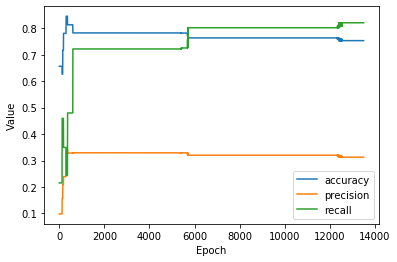

In [90]:
list_of_metrics_to_plot = ['accuracy', 'precision', 'recall'] 

plot_curve(epochs_list, hist, list_of_metrics_to_plot)

In [95]:
pd.concat([df_test,df_predict], axis=1).corr()

,0_test,1_test,2_test,3_test,4_test,5_test,6_test,7_test,8_test,9_test,...,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9,Class10
0_test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1_test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2_test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3_test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4_test,NaN,NaN,NaN,NaN,1.000000,0.034684,0.087796,-0.039706,0.151591,0.124426,...,0.004376,0.004432,0.004184,0.025742,0.035350,-0.006209,0.058378,0.054872,-0.036864,0.004520
5_test,NaN,NaN,NaN,NaN,0.034684,1.000000,-0.013469,0.147242,-0.085052,0.033243,...,-0.045552,-0.045419,-0.045757,-0.003781,0.043943,0.024677,0.016008,0.023856,-0.010486,-0.045191
6_test,NaN,NaN,NaN,NaN,0.087796,-0.013469,1.000000,-0.113709,0.042958,0.128629,...,-0.026796,-0.027111,-0.026309,-0.115520,-0.048007,-0.112643,-0.054529,-0.050680,0.103755,-0.027702
7_test,NaN,NaN,NaN,NaN,-0.039706,0.147242,-0.113709,1.000000,-0.052271,0.028856,...,-0.077622,-0.077565,-0.077479,-0.003979,0.023670,0.071866,-0.047575,-0.036645,0.019196,-0.077656
8_test,NaN,NaN,NaN,NaN,0.151591,-0.085052,0.042958,-0.052271,1.000000,-0.048305,...,0.054112,0.053925,0.054459,-0.012173,-0.068982,-0.015991,-0.053190,-0.057899,0.027468,0.053420
9_test,NaN,NaN,NaN,NaN,0.124426,0.033243,0.128629,0.028856,-0.048305,1.000000,...,0.000410,-0.000232,0.001573,-0.205803,-0.171317,-0.169639,-0.195047,-0.189919,0.219009,-0.001355
